# Task 3c. Pytorch Lightning

In [1]:
# Import libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

import pytorch_lightning as pl
from pytorch_lightning import callbacks, loggers
from pytorch_lightning import LightningDataModule, LightningModule
from pytorch_lightning import Trainer

from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

import os
import time
import pickle
import glob

In [2]:
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# !mkdir ./data/oxford-iiit-pet
# !cp -r /home/tungnguyendinh/.fastai/data/oxford-iiit-pet/images ./data/oxford-iiit-pet
# !ls ./data/oxford-iiit-pet/images

## Prepare data

In [4]:
data_dir = './data/oxford-iiit-pet/images'
save_dir = './saved'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
pathnames = glob.glob(os.path.join(data_dir, '*.jpg'))

# # Filter image with number of channels different from 3
# cnt = 0
# for path in pathnames:
#     image = plt.imread(path)
#     if len(image.shape) == 3:
#         if image.shape[2] != 3:
#             !rm -f "{path}"
#             cnt += 1
            
#     else:
#         !rm -f "{path}"
#         cnt += 1
# print(f'Deleted {cnt} invalid images!')        


# Label processing
labellist = []
all_labels = []
for path in pathnames:
    image_name = path.split('/')[-1]
    label = '_'.join(image_name.split('_')[:-1])
    all_labels.append(label)
    
labellist = list(sorted(set(all_labels)))
num_labels = len(labellist)
print('Number of labels: ', len(labellist))

Number of labels:  37


In [5]:
# Save label list
pickle.dump(labellist, open(os.path.join(save_dir, 'labels.sav'), 'wb'))

In [6]:
pathnames = np.array(pathnames)
all_labels = np.array(all_labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

train_index, test_index = next(sss.split(pathnames, all_labels))
trainpaths, trainlabels = pathnames[train_index], all_labels[train_index]
testpaths, testlabels = pathnames[test_index], all_labels[test_index]

train_index, val_index = next(sss.split(trainpaths, trainlabels))
trainpaths, trainlabels = pathnames[train_index], all_labels[train_index]
valpaths, vallabels = pathnames[val_index], all_labels[val_index]

print('Train size: ', len(trainpaths))
print('Valid size: ', len(valpaths))
print('Test size: ', len(testpaths))

Train size:  4721
Valid size:  1181
Test size:  1476


In [7]:
paths = {
    'train': trainpaths,
    'val': valpaths,
    'test': testpaths
}

Labels = {
    'train': trainlabels,
    'val': vallabels,
    'test': testlabels
}

In [8]:
# Define dataset class
class PetDataset(Dataset):
    def __init__(self, pathnames, labels, labellist, transforms=None, mode='train'):
        super().__init__()
        
        self.pathnames = pathnames
        self.labels = labels
        self.labellist = labellist
        self.num_classes = len(self.labellist)
        self.num_samples = len(self.pathnames)
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index):
        path = self.pathnames[index]
        
        # Process image
        image = plt.imread(path)
        if self.transforms:
            image = self.transforms[self.mode](image)

        label = self.labels[self.mode][index]
        label_index = self.labellist.index(label)
        # label_onehot = F.one_hot(torch.tensor(label_index), num_classes=self.num_classes)
        label_index = torch.tensor(label_index)
        return image, label_index          
    
    def __len__(self):
        return self.num_samples

In [9]:
# Test dataset
dataset = PetDataset(pathnames, Labels, labellist, {'train': transforms.ToTensor()})
image, label = dataset[0]
print(image.shape, label.shape)

torch.Size([3, 333, 500]) torch.Size([])


./data/oxford-iiit-pet/images/Siamese_194.jpg
american_pit_bull_terrier


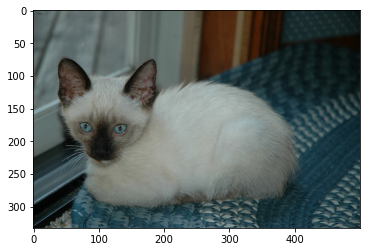

In [10]:
plt.imshow(image.permute(1, 2, 0).numpy())
print(pathnames[0])
print(labellist[label.item()])

In [11]:
# Transforms
# ImageNet info
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

datatransforms = {
    
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean, std)
    ]),
    
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean, std)
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean, std)
    ])
}

In [12]:
# Dataset
datasets = {x : PetDataset(paths[x], Labels, labellist, datatransforms, mode=x) for x in ['train', 'val', 'test']}

In [13]:
class LitDataModule(LightningDataModule):
    def __init__(self, datasets, batch_size):
        super().__init__()
        
        self.datasets = datasets
        self.batch_size = batch_size
    
    def train_dataloader(self):
        return DataLoader(datasets['train'], self.batch_size, shuffle=True, num_workers=12)
    
    def val_dataloader(self):
        return DataLoader(datasets['val'], self.batch_size, shuffle=False, num_workers=12)
    
    def test_dataloader(self):
        return DataLoader(datasets['test'], self.batch_size, shuffle=False, num_workers=12)

## Prepare model

In [14]:
pretrained_model = models.efficientnet_b0(pretrained=True)
print(pretrained_model)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [15]:
# Define model
class FinetuneEfficientNetB0(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.pretrained_model = pretrained_model
        self.num_classes = num_classes
        
        in_features = self.pretrained_model.classifier[1].in_features
        self.pretrained_model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, 128),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(128, self.num_classes)
        )
        
    def forward(self, x):
        return self.pretrained_model(x)

In [16]:
class LitModule(LightningModule):
    def __init__(self,pretrained_model, labellist, learning_rate=0.01, momentum=0.9):
        super().__init__()
        
        self.pretrained_model = pretrained_model
        self.labellist = labellist
        self.num_classes = len(labellist)
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.model = FinetuneEfficientNetB0(self.pretrained_model, self.num_classes)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.momentum)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_index):
        images, labels = batch
        
        outputs = self(images)
        _, preds = torch.max(outputs, dim=1)
        
        loss = self.loss(outputs, labels)
        corrects = torch.sum(preds == labels.data)
        accuracy = corrects / labels.size(0)
        
        return {
            'loss': loss,
            'log': {
                'acc': accuracy
            }
        }
    
    def validation_step(self, batch, batch_index):
        images, labels = batch
        
        outputs = self(images)
        _, preds = torch.max(outputs, dim=1)
        
        loss = self.loss(outputs, labels)
        corrects = torch.sum(preds == labels.data)
        accuracy = corrects / labels.size(0)
        
        return {
            'loss': loss,
            'log': {
                'acc': accuracy
            }
        }

    
    def test_step(self, batch, batch_index):
        images, labels = batch
        
        outputs = self(images)
        _, preds = torch.max(outputs, dim=1)
        
        loss = self.loss(outputs, labels)
        corrects = torch.sum(preds == labels.data)
        accuracy = corrects / labels.size(0)
        
        self.log('test/loss', loss)
        self.log('test/accuracy', accuracy)
        return {
            'loss': loss,
            'log': {
                'acc': accuracy
            }
        }
    
    def configure_callbacks(self):
        return [
            callbacks.EarlyStopping(monitor='val/accuracy', mode='max', patience=10, verbose=1),
            callbacks.ModelCheckpoint(os.path.join(save_dir, 'checkpoints'), monitor='val/accuracy', mode='max', save_weights_only=True, verbose=1)
        ]

### Trainer

In [17]:
# Callbacks
# Logging Callback
class MyLoggingCallback(pl.callbacks.Callback):
    def __init__(self, every_batch=100):
        super().__init__()
        self.every_batch = every_batch

    # Train
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused=0): 
        # Calculate and log batch accuracy
        self.log('train/loss', outputs['loss'])
        self.log('train/accuracy', outputs['log']['acc'])
    
    # Valid 
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused=0): 
        # Calculate and log batch accuracy
        self.log('val/loss', outputs['loss'])
        self.log('val/accuracy', outputs['log']['acc'])
        
    
    # Test
    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, unused=0): 
        # Calculate and log batch accuracy
        self.log('test/loss', outputs['loss'])
        self.log('test/accuracy', outputs['log']['acc'])
        
# Visualization Callback
class MyVisualizationCallback(pl.callbacks.Callback):
    
    def teardown(self, trainer, pl_module, stage=None):
        if stage:
            if stage == 'fit':
                pl_module.logger.experiment.add_image('filters', self.get_kernels(pl_module))
                
            # Visualize model    
            sampleImg=torch.rand((32, 3, 224, 224))
            pl_module.logger.experiment.add_graph(pl_module.model,sampleImg)
                
    def get_kernels(self, pl_module):
        kernels = pl_module.model.pretrained_model.features[0][0].weight.detach().cpu()
        
        # Min max scale
        kernels = (kernels - kernels.min()) / kernels.max()
        filters = torchvision.utils.make_grid(kernels.clamp(0, 1))
        return filters  

In [18]:
# logger = loggers.TensorBoardLogger()

batch_size = 64
learning_rate = 0.005
momentum = 0.9
num_epochs = 100

# logger
logger = loggers.TensorBoardLogger('runs', 'lightning_c')

trainer = Trainer(
    fast_dev_run=False,
    log_every_n_steps=10,
    gpus=[2],
    max_epochs=num_epochs,
    logger=logger,
    callbacks=[MyLoggingCallback(), MyVisualizationCallback()]
)

litdatamodule = LitDataModule(datasets, batch_size)
litmodel = LitModule(pretrained_model, labellist, learning_rate, momentum)
print(litmodel)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LitModule(
  (pretrained_model): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [19]:
trainer.fit(litmodel, litdatamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type                   | Params
------------------------------------------------------------
0 | pretrained_model | EfficientNet           | 4.2 M 
1 | model            | FinetuneEfficientNetB0 | 4.2 M 
2 | loss             | CrossEntropyLoss       | 0     
------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.705    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved. New best score: 0.655
Epoch 0, global step 74: 'val/accuracy' reached 0.65538 (best 0.65538), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=0-step=74.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.204 >= min_delta = 0.0. New best score: 0.859
Epoch 1, global step 148: 'val/accuracy' reached 0.85944 (best 0.85944), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=1-step=148.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.036 >= min_delta = 0.0. New best score: 0.896
Epoch 2, global step 222: 'val/accuracy' reached 0.89585 (best 0.89585), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=2-step=222.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.012 >= min_delta = 0.0. New best score: 0.908
Epoch 3, global step 296: 'val/accuracy' reached 0.90771 (best 0.90771), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=3-step=296.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.913
Epoch 4, global step 370: 'val/accuracy' reached 0.91279 (best 0.91279), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=4-step=370.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.009 >= min_delta = 0.0. New best score: 0.922
Epoch 5, global step 444: 'val/accuracy' reached 0.92210 (best 0.92210), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=5-step=444.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.924
Epoch 6, global step 518: 'val/accuracy' reached 0.92379 (best 0.92379), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=6-step=518.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.930
Epoch 7, global step 592: 'val/accuracy' reached 0.92972 (best 0.92972), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=7-step=592.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.932
Epoch 8, global step 666: 'val/accuracy' reached 0.93226 (best 0.93226), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=8-step=666.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 740: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 814: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.936
Epoch 11, global step 888: 'val/accuracy' reached 0.93649 (best 0.93649), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=11-step=888.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 962: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.937
Epoch 13, global step 1036: 'val/accuracy' reached 0.93734 (best 0.93734), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=13-step=1036.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Metric val/accuracy improved by 0.003 >= min_delta = 0.0. New best score: 0.941
Epoch 14, global step 1110: 'val/accuracy' reached 0.94073 (best 0.94073), saving model to '/home/anhtranthe/workspace/3_pytorch/saved/checkpoints/epoch=14-step=1110.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1184: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1258: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1332: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1406: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 1480: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 1554: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 1628: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 1702: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 1776: 'val/accuracy' was not in top 1


Validation: 0it [00:00, ?it/s]

Monitored metric val/accuracy did not improve in the last 10 records. Best score: 0.941. Signaling Trainer to stop.
Epoch 24, global step 1850: 'val/accuracy' was not in top 1


In [20]:
trainer.test(litmodel, litdatamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9661246538162231
        test/loss           0.10429704189300537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.10429704189300537, 'test/accuracy': 0.9661246538162231}]

In [21]:
# !tensorboard --logdir=runs/lightning_c